# Data Challenge: Tierzählstation

## Szenario: 

Dir liegt die Artenvielfalt sehr am Herzen, also möchtest du eine lokale Tierzählstation dabei unterstützen, ihre Arbeit zu digitalisieren. Eine Tierzählstation soll für ein konkretes Gebiet untersuchen, welche Arten in welcher Häufigkeit vorhanden sind. Aktuell gibt es an der Tierzählstation eine Kamera-Vorrichtung, die durch eine Lichtschranke ausgelöst wird. Die Fotos werden gespeichert und dann müssen freiwillige Helfer die Fotos sichten und den verschiedenen Tierarten zuordnen. Aus der (relativen) Häufigkeit mit der bestimmte Tierarten auf den Bildern erscheinen, lassen sich Rückschlüsse auf die jeweiligen Populationen im Einzugsgebiet ableiten. 

Hier soll das aktuelle Projekt ansetzen! Ziel ist es, eine KI zu entwickeln, die automatisiert erkennt, welche Tierarten auf den Fotos zu sehen sind. Wenn die KI zuverlässig Tierarten zuordnen kann, kann die Analyse der jeweiligen Populationen automatisiert erfolgen. 

Im Prinzip bist du frei in der Wahl der Methoden und Techniken, aber wenn du noch nicht mit Bildern oder generell Computer Vision gearbeitet hast, empfehlen wir dir, vorher unsere Kurse **Quickstart Deep Learning** und **Bildklassifikation mit CNNs** durchzuarbeiten. 

Die Challenge ist so angelegt, dass sie sich gut dazu eignet, das dort gewonnene Wissen in der Praxis zu erproben. An manchen Stellen gibt es noch einige Hilfestellungen, die besonders für Absolvierende dieser Kurse konzipiert wurden, um den Einstieg zu erleichtern. Du kannst aber auch unabhängig von unseren Hilfestellungen an dem Projekt arbeiten.

Jetzt beginnen wir erstmal damit, ein paar nützliche Pakete und die Daten zu laden. 

In [1]:
# Matplotlib zum Anzeigen von Plots
%matplotlib inline
import matplotlib.pyplot as plt

# Numpy zur Bearbeitung der Daten
import numpy as np
np.random.seed(42)

# Suppressing some warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

from functions import plot_performance, save_predict, prepare_data, plot_images

# Trainingsdaten mit Labels
train_features = np.load('train_features_1.npy')
train_labels = np.load('train_labels_1.npy')
num_labels = len(np.unique(train_labels))

# Validierungsdaten mit Labels
validation_features = np.load('train_features_2.npy')
validation_labels = np.load('train_labels_2.npy')

# Testdaten ohne Labels
test_features = np.load('test_features.npy')


print(train_features.shape)
print(f"Unique labels: {num_labels}")
print("Done")

(24000, 32, 32, 1)
Unique labels: 6
Done


## Die Daten

In der Vergangenheit wurden vor allem folgende Tierarten registriert:

* Vögel,
* Katzen,
* Rehe/Hirsche,
* Hunde,
* Frösche,
* Pferde.

Manche dieser Tiere sind im Einzugsgebiet der Station heimisch, bei anderen handelt es sich um domestizierte Haus- und Nutztiere der Anwohner:innen. Die Tierzählstation stellt dir eine Anzahl von Bildern dieser Tierarten zur Verfügung. Dein Ziel ist es nun, eine KI zu entwickeln, die alle diese Tierarten mit hoher Genauigkeit zuordnen kann. Bevor es zur Challenge geht, solltest du dir noch mal einen Überblick über die Daten verschaffen. Die folgende Codezelle gibt dir schon mal einen groben Überblick. Du darfst dich aber gerne so viel du magst und kannst mit den Daten auseinandersetzen!

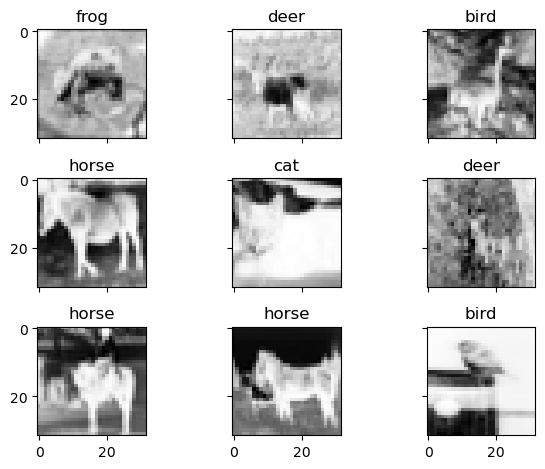

In [2]:
plot_images(
    train_features,
    train_labels
)

Es handelt sich um Schwarz-Weiß-Fotos mit einer relativ geringen Auflösung von 32x32 Pixeln. Dabei fällt auf, dass wir auch als Menschen in einzelnen Fällen vor einigen Problemen stehen würden, die Bilder korrekt zuzuordnen. Es wird spannend zu sehen, wie sich deine KI schlägt. 

Um die Daten vorzubereiten, führe die nächste Codezelle aus. Danach sollten die Daten so vorliegen, wie du es aus dem Training **Bildklassifikation mit CNNs** gewohnt bist. Wenn du die Daten selbstständig aufbereiten willst, arbeite lieber mit den vorher geladenen Daten (`train_features` und `train_labels`) weiter.

In [3]:
print(train_features.shape)
train_features, train_labels, validation_features, validation_labels, test_features, label_to_index = prepare_data(
    train_features,
    train_labels,
    validation_features,
    validation_labels,
    test_features
)
print(train_features.shape)
print(train_labels)
print(train_features)

(24000, 32, 32, 1)
(24000, 1, 32, 32)
tensor([4, 2, 0,  ..., 1, 4, 1])
[[[[0.23921569 0.17254902 0.1882353  ... 0.5372549  0.50980395
    0.5019608 ]
   [0.07058824 0.         0.03921569 ... 0.36862746 0.3529412
    0.36862746]
   [0.09019608 0.03137255 0.12156863 ... 0.3529412  0.3529412
    0.3137255 ]
   ...
   [0.6745098  0.6        0.6117647  ... 0.52156866 0.13725491
    0.14901961]
   [0.57254905 0.5019608  0.56078434 ... 0.59607846 0.27058825
    0.23137255]
   [0.5882353  0.53333336 0.57254905 ... 0.7372549  0.48235294
    0.38431373]]]


 [[[0.09411765 0.12941177 0.13333334 ... 0.25882354 0.2784314
    0.29411766]
   [0.10588235 0.11372549 0.10196079 ... 0.32156864 0.3254902
    0.28235295]
   [0.1254902  0.12941177 0.19607843 ... 0.30588236 0.35686275
    0.30980393]
   ...
   [0.28627452 0.3019608  0.2901961  ... 0.36078432 0.3254902
    0.2901961 ]
   [0.2901961  0.29803923 0.30980393 ... 0.28627452 0.27058825
    0.29411766]
   [0.31764707 0.30588236 0.3019608  ... 0.1803

## Modellierung

Nun bist du an der Reihe. Die Daten sind bereit, nun ist es an dir, ein Modell zu entwickeln, dass die Tierbilder bestmöglich zuordnet. 

Ziel ist es, die *accuracy* zu maximieren. Das entspricht dem Anteil der korrekt vorhergesagten Bilder. Dies ist hier eine sinnvolle Wahl, weil alle Kategorien die gleiche Wichtigkeit besitzen. Wie dir vielleicht schon vorher aufgefallen ist, sind die unterschiedlichen Kategorien gleich häufig im Datensatz. Daher sollte es durch die Wahl der *accuracy* als Zielmetrik in dieser Hinsicht keine Probleme geben. 

Lade am besten zunächst alle relevanten Bibliotheken und Module. Außerdem ist es vielleicht sinnvoll, erstmal mit einem möglichst einfachen Modell zu starten und es Schritt für Schritt auszubauen. 

Es ist am einfachsten, wenn du dein Modell einfach `model` nennst. Wenn du mehrere Modelle gleichzeitig trainierst, kannst du davon abweichen, musst dann aber an manchen Stellen weiter unten den Code entsprechend anpassen. 

### Data Loader

In [4]:
from torch.utils.data import Dataset, DataLoader

class AnimalDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.features[idx], self.labels[idx]
        else:
            return self.features[idx]

batch_size = 16
train_dataset = AnimalDataset(train_features, train_labels)
validation_dataset = AnimalDataset(validation_features, validation_labels)
test_dataset = AnimalDataset(test_features, None)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)
print("Done")

Done


### Network Setup

In [5]:
import torch
from torch import nn
import torch.nn.functional as F

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class AnimalNet(nn.Module):
    def __init__(self):
        super(AnimalNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(256 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_labels)
        )
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

Using cpu device


### Training

In [6]:
# Training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader): 
        # Forward pass
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print progress
        if batch % 100 == 0:
            current = batch * batch_size + len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{len(dataloader.dataset):>5d}]")

    return train_loss / len(dataloader)

# Validation loop
def validation_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    accuracy = 0
    predictions = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            prediction = logits.argmax(1)
            predictions.extend(prediction)
            test_loss += loss_fn(logits, y).item()
            accuracy += (prediction == y).type(torch.float).sum().item()

    test_loss /= len(dataloader)
    accuracy /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss, predictions

# Test loop
def test_loop(dataloader, model):
    model.eval()
    predictions = []
    with torch.no_grad():
        for X in dataloader:
            X = X.to(device)
            logits = model(X)
            predictions.extend(logits.argmax(1).tolist())
    return predictions

# Model parameters
model = AnimalNet().to(device)
print(model)
learning_rate = 0.001
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Run model
train_losses = []
validation_losses = []
validation_predictions = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_losses.append(train_loop(train_dataloader, model, loss_fn, optimizer))
    validation_loss, validation_prediction = validation_loop(validation_dataloader, model, loss_fn)
    validation_losses.append(validation_loss)
    validation_predictions.append(validation_prediction)
    scheduler.step()

test_predictions = test_loop(test_dataloader, model)

plt.plot(train_losses)
plt.plot(validation_losses)
print("Done")


AnimalNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_

## Evaluierung

Wenn du dir die Performance deines Modells über verschiedene Epochen anschauen möchtest, kannst du die folgende Zeile ausführen. Dafür ist es wichtig, dass du vorher das Ergebnis von `my_model.fit()` in der Variable `history` speicherst.  

{'bird': 0, 'cat': 1, 'deer': 2, 'dog': 3, 'frog': 4, 'horse': 5}
Prediction: 1, Label: 4


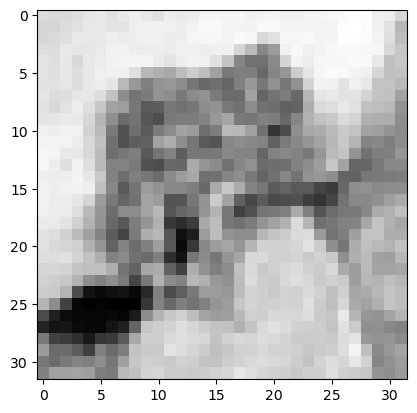

In [ ]:
index = 0
print(label_to_index)
print(f"Prediction: {validation_predictions[-1][index]}, Label: {validation_labels[index]}")
plt.imshow(validation_features[index].squeeze(), cmap='gray')

## Abschluss der Challenge

Wenn du ein Modell gefunden hast, mit dem du zufrieden bist, kannst du nun die Vorhersage für die Challenge generieren. Wenn dein Modell `model` heißt, kannst du einfach die nächsten zwei Codezellen ausführen, ansonsten musst du `model` durch den tatsächlichen Namen deines Modells ersetzen. 

Die folgende Zelle führt mit deinen Modell `model` Vorhersagen durch und speichert diese Vorhersagen in der Variable `predictions`. 

Wenn du die folgende Zelle ausführst, werden die in `predictions` gespeicherten Vorhersagen in einer Datei `predictions.npy` gesichert. Vorher wird grob überpüft, ob deine Vorhersagen dem generellen Format entspricht. Falls nicht, wird eine Fehlermeldung generiert. 

Wenn alle Formalien erfüllt sind, erhältst du den Hinweis, dass das Speichern beginnt und schlussendlich ob das Speichern erfolgreich war. 

In [ ]:
save_predict(predictions)

NameError: name 'predictions' is not defined

Die Datei `predictions.npy` kannst du nun herunterladen und danach für die Challenge einreichen! Dazu solltest du in der linken Taskleiste hier in der Programmierumgebung das Ordner-Symbol anklicken und in der Liste der Dateien die Datei `predictions.npy` finden. Per Rechtsklick und durch Auswahl von "Download" lässt sich die Datei dann herunterladen.

*Herzlichen Glückwunsch zum Abschluss der Challenge!*

Die hier verwendeten Daten basieren auf dem CIFAR-10 Data Set. 

https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.